# AutoML: Train "the best" Image Classification Multi-Class model for a 'Fridge items' dataset.

**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription. [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace. [Check this notebook for creating a workspace](/sdk/resources/workspace/workspace.ipynb) 
- A Compute Cluster. [Check this notebook to create a compute cluster](/sdk/resources/compute/compute.ipynb)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](/sdk/README.md#getting-started)

**Learning Objectives** - By the end of this tutorial, you should be able to:
- Connect to your AML workspace from the Python SDK
- Create an `AutoML Image Classification Multiclass Training Job` with the 'image_classification()' factory-function.
- Train the model using AmlCompute by submitting/running the AutoML training job
- Obtaing the model and score predictions with it

**Motivations** - This notebook explains how to setup and run an AutoML image classification-multiclass job. This is one of the nine ML-tasks supported by AutoML. Other ML-tasks are 'forecasting', 'classification', 'image object detection', 'nlp text classification', etc.

In this notebook, we go over how you can use AutoML for training an Image Classification Multi-Class model. We will use a small dataset to train the model, demonstrate how you can tune hyperparameters of the model to optimize model performance and deploy the model to use in inference scenarios. 

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [1]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.identity import InteractiveBrowserCredential
from azure.ml import MLClient

from azure.ml._constants import AssetTypes
from azure.ml.entities import JobInput

from azure.ml.entities import ImageClassificationSearchSpace, Choice, Uniform, BanditPolicy, JobInput

from azure.ml import automl
# from azure.ml.automl import image_classification

from pprint import pprint

## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [interactive authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.interactivebrowsercredential?view=azure-python) for this tutorial. More advanced connection methods can be found [here](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity?view=azure-python).

In [2]:
#Enter details of your AML workspace

# CDLTLL-GPU
# subscription_id = '381b38e9-9840-4719-a5a0-61d9585e1e91' #'<SUBSCRIPTION_ID>'
# resource_group = 'cesardl-automl-eastus2euap-resgrp' # '<RESOURCE_GROUP>'
# workspace = 'cesardl-dist-training-eastus-ws' # '<AML_WORKSPACE_NAME>'

# SAGAR
# subscription_id = "381b38e9-9840-4719-a5a0-61d9585e1e91" #'<SUBSCRIPTION_ID>'
# resource_group = "sasum_centraluseuap_rg" # '<RESOURCE_GROUP>'
# workspace = "sasum-centraluseuap-ws" # '<AML_WORKSPACE_NAME>'

# CDLTLL
# subscription_id = '102a16c3-37d3-48a8-9237-4c9b1e8e80e0' #'<SUBSCRIPTION_ID>'
# resource_group = 'automlpmdemo' # '<RESOURCE_GROUP>'
# workspace = 'cesardl-automl-centraluseuap-ws' # '<AML_WORKSPACE_NAME>'

# JUAMARTI
subscription_id = "381b38e9-9840-4719-a5a0-61d9585e1e91"
resource_group = "juamarti"
workspace = "centraluseuap_phmantri"

In [3]:
#get a handle to the workspace
credential = InteractiveBrowserCredential() # DefaultAzureCredential()
#credential = DefaultAzureCredential()
ml_client = MLClient(credential, subscription_id, resource_group, workspace)

# 2. Data

Load the 'fridge items' dataset from a JSON file and MLTable definition.

In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an Azure Machine Learning MLTable. 

In this notebook, we use a toy dataset called Fridge Objects, which consists of 134 images of 4 classes of beverage container {can, carton, milk bottle, water bottle} photos taken on different backgrounds.

All images in this notebook are hosted in [this repository](https://github.com/microsoft/computervision-recipes) and are made available under the [MIT license](https://github.com/microsoft/computervision-recipes/blob/master/LICENSE).

**NOTE:** In this PRIVATE PREVIEW we're defining the MLTable in a separate folder and .YAML file.
In later versions, you'll be able to do it all in Python APIs.

In [ ]:
import os
import urllib
from zipfile import ZipFile

# download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/image_classification/fridgeObjects.zip"
data_file = "./fridgeObjects.zip"
urllib.request.urlretrieve(download_url, filename=data_file)

# extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall()
    print("done")
# delete zip file
os.remove(data_file)

This is a sample image from this dataset:

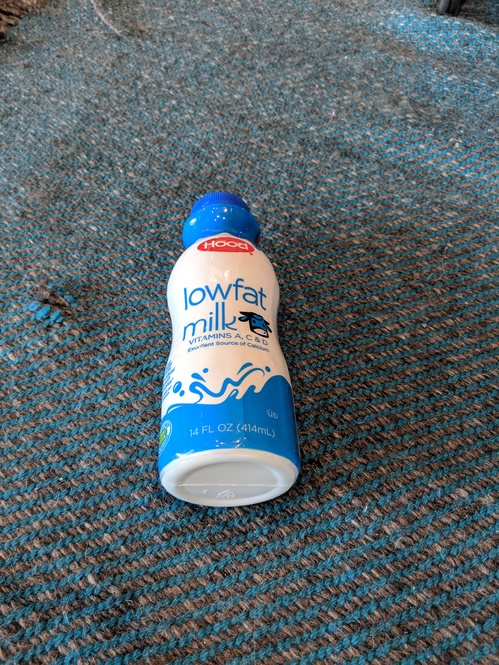

In [4]:
from IPython.display import Image

sample_image = "./fridgeObjects/milk_bottle/99.jpg"
Image(filename=sample_image)

### Upload the images to Datastore through an AML Data asset (URI Folder)

In order to use the data for training in Azure ML, we upload it to our default Azure Blob Storage of our  Azure ML Workspace.

Reference to URI FOLDER data asset example for further details: https://github.com/Azure/azureml-examples/blob/samuel100/data-samples/sdk/assets/data/data.ipynb

In [8]:
# Uploading image files by creating a 'data asset URI FOLDER':

from azure.ml.entities import Data
from azure.ml._constants import AssetTypes

my_data = Data(
    path="./fridgeObjects",
    type=AssetTypes.URI_FOLDER,
    description="Fridge-items images",
    name="fridge-items-images",
    version='2'
)

uri_folder_data_asset = ml_client.data.create_or_update(my_data)

print(uri_folder_data_asset)
print("")
print("Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)


Data({'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'fridge-items-images', 'description': 'Fridge-items images', 'tags': {}, 'properties': {}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/juamarti/providers/Microsoft.MachineLearningServices/workspaces/centraluseuap_phmantri/data/fridge-items-images/versions/2', 'base_path': './', 'creation_context': <azure.ml._restclient.v2022_02_01_preview.models._models_py3.SystemData object at 0x0000027791240F88>, 'serialize': <msrest.serialization.Serializer object at 0x000002779123F848>, 'version': '2', 'latest_version': None, 'path': 'azureml://subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/juamarti/workspaces/centraluseuap_phmantri/datastores/workspaceblobstore/paths/LocalUpload/c6876bbc27a0df81f0e4ed8195c62311/fridgeObjects'})

Path to folder in Blob Storage:
azureml://subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/juamarti/workspaces/cent

In [7]:
# Test access to the registered data asset URI-FOLDER if not uploading files.

uri_folder_data_asset = ml_client.data.get(name="fridge-items-images", version="2")

print(uri_folder_data_asset)

Data({'type': 'uri_folder', 'is_anonymous': False, 'auto_increment_version': False, 'name': 'fridge-items-images', 'description': 'Fridge-items images', 'tags': {}, 'properties': {}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/juamarti/providers/Microsoft.MachineLearningServices/workspaces/centraluseuap_phmantri/data/fridge-items-images/versions/2', 'base_path': './', 'creation_context': <azure.ml._restclient.v2022_02_01_preview.models._models_py3.SystemData object at 0x0000027791207DC8>, 'serialize': <msrest.serialization.Serializer object at 0x000002779015AB08>, 'version': '2', 'latest_version': None, 'path': 'azureml://subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/juamarti/workspaces/centraluseuap_phmantri/datastores/workspaceblobstore/paths/LocalUpload/c6876bbc27a0df81f0e4ed8195c62311/fridgeObjects'})


### Convert the downloaded data to JSON metadata

In this example, the fridge object dataset is stored in a directory. There are four different folders inside:

/water_bottle
/milk_bottle
/carton
/can

This is the most common data format for multiclass image classification. Each folder title corresponds to the image label for the images contained inside.

In order to use this data to create an AzureML MLTable, we first need to convert it to the required JSONL format. 

The following script is creating two .jsonl files (one for training and one for validation) in the parent folder of the dataset. The train / validation ratio corresponds to 20% of the data going into the validation file.

In [9]:
import json
import os

src_images = "./fridgeObjects/"

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = "./training-mltable-folder/"
validation_mltable_path = "./validation-mltable-folder/"

train_validation_ratio = 5

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(validation_mltable_path, "validation_annotations.jsonl")

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": "",
}

index = 0
# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for className in os.listdir(src_images):
            subDir = src_images + className
            if not os.path.isdir(subDir):
                continue
            # Scan each sub directary
            print("Parsing " + subDir)
            for image in os.listdir(subDir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"/{className}/{image}"
                json_line["label"] = className

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")
                index += 1

Parsing ./fridgeObjects/can
Parsing ./fridgeObjects/carton
Parsing ./fridgeObjects/milk_bottle
Parsing ./fridgeObjects/water_bottle


In [27]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = JobInput(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = JobInput(type=AssetTypes.MLTABLE, path=validation_mltable_path)

# WITH REMOTE PATH: If available already in the cloud/workspace-blob-store
# my_training_data_input = JobInput(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/train")
# my_validation_data_input = JobInput(type=AssetTypes.MLTABLE, path="azureml://datastores/workspaceblobstore/paths/vision-classification/valid")    

# 3. Configure and run the AutoML for Images Classification-Multiclass training job
In this section we will configure and run the AutoML job, for training the model.

## 3.1 Configure the job through the image_classification() factory function

### image_classification() function parameters:

The `image_classification()` factory function allows user to configure the training job.

- `target_column_name` - The name of the column to target for predictions. It must always be specified. This parameter is applicable to 'training_data', 'validation_data' and 'test_data'.
- `primary_metric` - The metric that AutoML will optimize for model selection.
- `training_data` - The data to be used for training. It should contain both training feature columns and a target column. Optionally, this data can be split for segregating a validation or test dataset. 
You can use a registered MLTable in the workspace using the format '<mltable_name>:<version>' OR you can use a local file or folder as a MLTable. For e.g JobInput(mltable='my_mltable:1') OR JobInput(mltable=MLTable(local_path="./data"))
The parameter 'training_data' must always be provided.
- `compute` - The compute on which the AutoML job will run. In this example we are using a compute called 'cpu-cluster' present in the workspace. You can replace it any other compute in the workspace. 
- `name` - The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
- `experiment_name` - The name of the Experiment. An Experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.

### set_limits() parameters:
This is an optional configuration method to configure limits parameters such as timeouts.     
    
- timeout_minutes - Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. This timeout includes setup, featurization and training runs but does not include the ensembling and model explainability runs at the end of the process since those actions need to happen once all the trials (children jobs) are done. If not specified, the default job's total timeout is 6 days (8,640 minutes). To specify a timeout less than or equal to 1 hour (60 minutes), make sure your dataset's size is not greater than 10,000,000 (rows times column) or an error results.

- trial_timeout_minutes - Maximum time in minutes that each trial (child job) can run for before it terminates. If not specified, a value of 1 month or 43200 minutes is used.
    
- max_trials - The maximum number of trials/runs each with a different combination of algorithm and hyperparameters to try during an AutoML job. If not specified, the default is 1000 trials. If using 'enable_early_termination' the number of trials used can be smaller.
    
- max_concurrent_trials - Represents the maximum number of trials (children jobs) that would be executed in parallel. It's a good practice to match this number with the number of nodes your cluster.
    
- enable_early_termination - Whether to enable early termination if the score is not improving in the short term. 
    

In [29]:
# Create the AutoML job with the related factory-function.

image_classification_job = automl.image_classification(
                        compute = "gpu-cluster",
                        # name="dpv2-image-classification-job-02",
                        experiment_name = "dpv2-image-classification-experiment",
                        training_data = my_training_data_input,
                        validation_data = my_validation_data_input,
                        target_column_name = "label",
                        primary_metric = "accuracy",
                        tags={"owner": "cesardl"},
                        
                        # These are temporal properties needed in Private Preview
                        properties={
                            "_automl_internal_enable_mltable_quick_profile": True,
                            "_automl_internal_label": "latest"
                            # "_automl_internal_scenario": "Vision-Candidate",
                        }
)
    
# Note, since Image classification sweeping is based on a Sweep/HyperDrive run, max_trials=1
# DEFAULTS:
image_classification_job.set_limits(max_trials=1, max_concurrent_trials=1)

image_classification_job.extend_search_space([
    ImageClassificationSearchSpace(
        model_name=Choice(["vitb16r224", "vits16r224"]),
        learning_rate=Uniform(0.001, 0.01),
        number_of_epochs=Choice([15, 30]),
    ),
    ImageClassificationSearchSpace(
        model_name=Choice(["seresnext", "resnet50"]),
        learning_rate=Uniform(0.001, 0.01),
        layers_to_freeze=Choice([0, 2]),
    )
])

image_classification_job.set_sweep(max_trials=10, max_concurrent_trials=2, sampling_algorithm="Random",
                             early_termination=BanditPolicy(
                                 evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
                             ))

## 2.2 Run the CommandJob
Using the `MLClient` created earlier, we will now run this CommandJob in the workspace.

In [30]:
# Submit the AutoML job (CDLTLL: Is it ml_client.create_or_update(regression_job))
returned_job = ml_client.jobs.create_or_update(image_classification_job)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: ImageClassificationJob({'task_type': <TaskType.IMAGE_CLASSIFICATION: 'ImageClassification'>, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'display_name': 'c3d997bb-fc74-4e42-9daf-7db00fc68312', 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'c3d997bb-fc74-4e42-9daf-7db00fc68312', 'description': None, 'tags': {'owner': 'cesardl'}, 'properties': {'_automl_internal_enable_mltable_quick_profile': 'True', '_automl_internal_label': 'latest', 'mlflow.source.git.repoURL': 'git@github.com:Azure/azureml-examples.git', 'mlflow.source.git.branch': 'automl-preview', 'mlflow.source.git.commit': '2db087c1524193c4e9061782970a912e8384537d', 'azureml.git.dirty': 'True'}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/juamarti/providers/Microsoft.MachineLearningServices/workspaces/centraluseuap_phmantri/jobs/c3d997bb-fc74-4e42-9daf-7db00fc68312', 'base_path': './', 'creation_context': <azure.ml._restclient.v2022_02_01_

In [31]:
# Get a URL for the status of the job
print("Open the following link to observe the AutoML training job/run:")

returned_job.services["Studio"].endpoint

Open the following link to observe the AutoML training job/run:


'https://ml.azure.com/runs/c3d997bb-fc74-4e42-9daf-7db00fc68312?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/juamarti/workspaces/centraluseuap_phmantri&tid=72f988bf-86f1-41af-91ab-2d7cd011db47'

# Next Steps
You can see further examples of other AutoML tasks such as Regression, Image-Object-Detection, NLP-Text-Classification, Time-Series-Forcasting, etc.